In [107]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import functools
import importlib
import numpy as np
sqrtm_cpp = importlib.import_module("sqrtm_cpp")
ewma = importlib.import_module("ewma")
start_date = pd.to_datetime('1952-12-31')

#Relevante paths
output_path = "./data_fifty/"
pickle_file_path = "./data_fifty/model_1.pkl"
wealth_path = "./data_fifty/wealth.csv"
barra_file_path = "./data_fifty/barra_cov.pkl"
output_path_market_returns = "data_fifty/market_returns_test.csv"

risk_free_path = "./data_fifty/risk_free_test.csv" 
output_data_ret_csv = "./data_fifty/data_ret.csv"  
output_data_ret_ld1_csv = "./data_fifty/data_ret_ld1.csv"

file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"

risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
daily_path = "./data_fifty/daily.csv"
chars_path = "./data_fifty/chars_behandlet.parquet"


Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [108]:
wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

In [135]:
with open(barra_file_path, "rb") as file:
    barra_cov = pickle.load(file)

In [136]:
barra_cov['2012-12-31']['fct_cov']

BusEq     Chems     Durbl     Enrgy          Hlth  \
BusEq                0.003107  0.002438  0.002721  0.002942  2.492657e-03   
Chems                0.002438  0.003302  0.002339  0.002767  2.259215e-03   
Durbl                0.002721  0.002339  0.004636  0.002746  2.237310e-03   
Enrgy                0.002942  0.002767  0.002746  0.004331  2.670450e-03   
Hlth                 0.002493  0.002259  0.002237  0.002670  2.613901e-03   
Manuf                0.002928  0.002539  0.002810  0.003273  2.506231e-03   
Money                0.002720  0.002262  0.002735  0.002756  2.457834e-03   
NoDur                0.002250  0.002093  0.002025  0.002392  2.105252e-03   
Other                0.002631  0.002337  0.002718  0.002803  2.312192e-03   
Shops                0.002297  0.002082  0.002290  0.002364  2.081322e-03   
Telcm                0.002336  0.002110  0.002326  0.002578  2.127785e-03   
Utils                0.002211  0.001949  0.002097  0.002391  1.978357e-03   
accruals            -0.000004 -0.000008 -0.000011 -0.000042 -3.264386e-06   
debt_issuance       -0.000009 -0.000004 -0.000031 -0.000025 -2.470838e-07   
investment           0.000039  0.000007  0.000051  0.000033  3.322279e-05   
low_leverage         0.000005  0.000032 -0.000015  0.000012 -2.690275e-06   
low_risk            -0.000590 -0.000496 -0.000587 -0.000601 -5.166303e-04   
momentum            -0.000121 -0.000069 -0.000104 -0.000104 -9.913396e-05   
profit_growth        0.000020  0.000019  0.000001  0.000037  1.071683e-05   
profitability        0.000057  0.000070  0.000060  0.000068  5.751164e-05   
quality             -0.000150 -0.000198 -0.000122 -0.000245 -1.826266e-04   
seasonality         -0.000038 -0.000039 -0.000051 -0.000024 -3.568357e-05   
short_term_reversal  0.000079  0.000054  0.000071  0.000087  6.640768e-05   
size                -0.000043 -0.000002 -0.000053 -0.000026 -3.539662e-05   
value                0.000031  0.000048 -0.000020  0.000006  3.854929e-05   

                        Manuf         Money     NoDur     Other     Shops  \
BusEq                0.002928  2.719936e-03  0.002250  0.002631  0.002297   
Chems                0.002539  2.261515e-03  0.002093  0.002337  0.002082   
Durbl                0.002810  2.734849e-03  0.002025  0.002718  0.002290   
Enrgy                0.003273  2.756272e-03  0.002392  0.002803  0.002364   
Hlth                 0.002506  2.457834e-03  0.002105  0.002312  0.002081   
Manuf                0.003332  2.728720e-03  0.002286  0.002711  0.002337   
Money                0.002729  3.296532e-03  0.002215  0.002640  0.002279   
NoDur                0.002286  2.215376e-03  0.002220  0.002119  0.001926   
Other                0.002711  2.640050e-03  0.002119  0.002755  0.002219   
Shops                0.002337  2.279127e-03  0.001926  0.002219  0.002287   
Telcm                0.002398  2.332165e-03  0.001995  0.002296  0.002038   
Utils                0.002242  2.305087e-03  0.001896  0.002171  0.001891   
accruals            -0.000001 -5.162217e-06  0.000009 -0.000027 -0.000017   
debt_issuance       -0.000012 -4.288031e-05 -0.000003 -0.000029 -0.000025   
investment           0.000043  9.469995e-05  0.000036  0.000044  0.000057   
low_leverage         0.000013 -3.761168e-05  0.000035  0.000006  0.000009   
low_risk            -0.000581 -6.245234e-04 -0.000496 -0.000552 -0.000492   
momentum            -0.000103 -1.619299e-04 -0.000093 -0.000096 -0.000099   
profit_growth        0.000033 -6.519108e-06  0.000014  0.000009  0.000011   
profitability        0.000061  4.842660e-05  0.000047  0.000044  0.000062   
quality             -0.000194 -9.504583e-05 -0.000172 -0.000112 -0.000151   
seasonality         -0.000038 -4.727279e-05 -0.000058 -0.000057 -0.000057   
short_term_reversal  0.000081  8.138463e-05  0.000070  0.000065  0.000064   
size                -0.000035 -9.920824e-05 -0.000039 -0.000046 -0.000027   
value                0.000021  3.075694e-07  0.000039  0.000030  0.000011   

                  

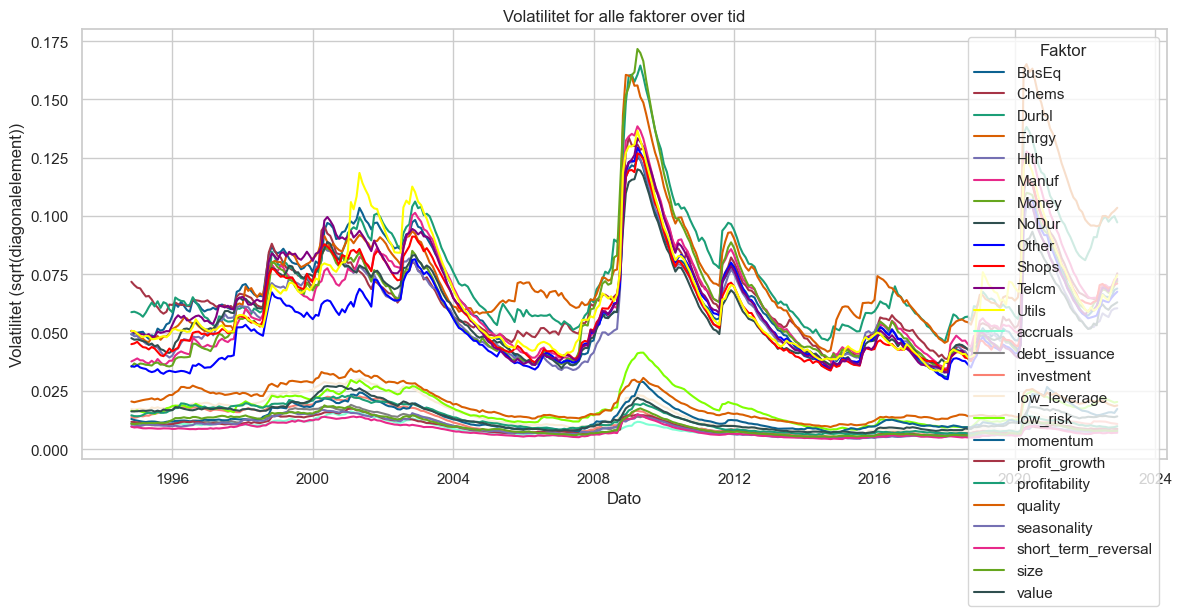

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forudsætning: barra_cov er en dictionary, hvor nøglerne er datoer,
# og hver værdi er en dictionary med en key 'fct_cov', der er en pandas DataFrame.
# Eksempel: barra_cov['2012-12-31']['fct_cov']

# Sorter datoerne
dates = sorted(barra_cov.keys())

# Hent faktornavne fra fct_cov for den første dato
first_date = dates[0]
factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Saml data: for hver dato og for hver faktor udregnes volatiliteten (sqrt af diagonalelementet)
records = []
for date in dates:
    df = barra_cov[date]['fct_cov']
    for factor in factor_names:
        vol = np.sqrt(df.loc[factor, factor])
        records.append({'date': pd.to_datetime(date), 'factor': factor, 'vol': vol})

# Konverter listen til en DataFrame
vol_data = pd.DataFrame(records)

# Plot: lav en linje for hver faktor over tid
plt.figure(figsize=(12, 6))
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    plt.plot(subset['date'], subset['vol'], label=factor)

plt.title("Volatilitet for alle faktorer over tid")
plt.xlabel("Dato")
plt.ylabel("Volatilitet (sqrt(diagonalelement))")
plt.legend(title="Faktor")
plt.tight_layout()
plt.show()


# Ny generering af chars

In [112]:
from Prepare_Data import process_cluster_labels
cluster_labels_path = "Data/Cluster Labels.csv"
factor_details_path = "Data/Factor Details.xlsx"

## Del 1 - Denne er korrekt

In [113]:
 # Indlæs cluster labels separat (bruger samme metode som i den anden version)


# Filtrer gyldige karakteristika
valid_chars = chars[chars["valid"] == True]
cluster_data_m = valid_chars[["id", "eom", "size_grp", "ff12"] + features].copy()
#print(cluster_data_m)
#print(cluster_data_m.shape)
cluster_labels = process_cluster_labels(cluster_labels_path, factor_details_path)
#print(cluster_labels)
#print(cluster_labels.shape)
clusters = cluster_labels["cluster"].unique()
cluster_ranks = {}

for cl in clusters:
    chars_sub = cluster_labels[(cluster_labels["cluster"] == cl) & (cluster_labels["characteristic"].isin(features))]

    # Undgå potentielle fejl ved at sikre, at kun eksisterende kolonner vælges
    valid_features = [c for c in chars_sub["characteristic"].values if c in cluster_data_m.columns]
    data_sub = cluster_data_m[valid_features].copy()

    for c in valid_features:
        dir_value = chars_sub.loc[chars_sub["characteristic"] == c, "direction"].values[0]
        if dir_value == -1:
            data_sub[c] = 1 - data_sub[c]

    cluster_ranks[cl] = data_sub.mean(axis=1)

# Konverter cluster ranks til DataFrame
cluster_ranks_df = pd.DataFrame(cluster_ranks)
# Kombiner med de oprindelige data
cluster_data_m = cluster_data_m[["id", "eom", "size_grp", "ff12"]].copy()
cluster_data_m["eom_ret"] = cluster_data_m["eom"] + pd.DateOffset(months=1)
cluster_data_m["eom_ret"] = cluster_data_m["eom_ret"] + MonthEnd(0)
# Merge cluster rankings
cluster_data_m = pd.concat([cluster_data_m, cluster_ranks_df], axis=1)

In [114]:
print(cluster_data_m.shape)

(68600, 18)


In [115]:
# Tilføj industry/market dummies
if settings["cov_set"]["industries"]:
    industries = sorted(cluster_data_m["ff12"].unique())
    for ind in industries:
        cluster_data_m[str(ind)] = (cluster_data_m["ff12"] == ind).astype(int)
    ind_factors = industries  # vi bruger ikke denne her?
else:
    cluster_data_m["mkt"] = 1
    ind_factors = ["mkt"]  # vi bruger ikke denne her?
print(cluster_data_m.shape)

(68600, 30)


In [116]:
# Standardiser faktorer per eom (Bruger samme metode som den anden version)
cluster_data_m[clusters] = cluster_data_m.groupby("eom")[clusters].transform(lambda x: (x - x.mean()) / x.std())

In [117]:
print(cluster_data_m.shape)

(68600, 30)


In [118]:
# Indlæs daglige returdata
min_eom = cluster_data_m["eom"].min()
daily_filtered = daily[daily["date"] >= min_eom][["id", "date", "ret_exc", "eom"]].copy()
daily_filtered.rename(columns={"eom": "eom_ret"}, inplace=True)

# Flet daglige data med cluster_data_m
cluster_data_d = cluster_data_m.merge(daily_filtered, on=["id", "eom_ret"], how="inner")
print(cluster_data_d)


            id        eom size_grp   ff12    eom_ret  low_leverage  \
0        10104 1988-11-30    large  BusEq 1988-12-31      2.007336   
1        10104 1988-11-30    large  BusEq 1988-12-31      2.007336   
2        10104 1988-11-30    large  BusEq 1988-12-31      2.007336   
3        10104 1988-11-30    large  BusEq 1988-12-31      2.007336   
4        10104 1988-11-30    large  BusEq 1988-12-31      2.007336   
...        ...        ...      ...    ...        ...           ...   
1440206  92655 2022-11-30     mega  Money 2022-12-31      0.469267   
1440207  92655 2022-11-30     mega  Money 2022-12-31      0.469267   
1440208  92655 2022-11-30     mega  Money 2022-12-31      0.469267   
1440209  92655 2022-11-30     mega  Money 2022-12-31      0.469267   
1440210  92655 2022-11-30     mega  Money 2022-12-31      0.469267   

         investment      size     value   quality  ...  Hlth  Manuf  Money  \
0         -1.646421  0.991330 -2.124264  1.793594  ...     0      0      0   
1  

In [119]:
print(cluster_data_d.shape)
# Fjern manglende værdier
cluster_data_d.dropna(inplace=True)
print(cluster_data_d.shape)

(1440211, 32)
(1440211, 32)


In [120]:
ind_factors

['BusEq',
 'Chems',
 'Durbl',
 'Enrgy',
 'Hlth',
 'Manuf',
 'Money',
 'NoDur',
 'Other',
 'Shops',
 'Telcm',
 'Utils']

## Del 2 - Denne er korrekt

In [121]:
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# Kombiner de forklarende variable
all_factors = list(ind_factors) + list(clusters)
formula = "ret_exc ~ -1 + " + " + ".join(all_factors)

results = []
# Gruppér data efter 'date'
for date, group in cluster_data_d.groupby('date'):
    # Kør regressionen uden intercept (-1)
    model = smf.ols(formula=formula, data=group).fit()
    # Udtræk residualer
    residuals = model.resid
    # Opret en "tidy" oversigt over regressionsresultaterne vha. summary2
    tidy_df = model.summary2().tables[1].reset_index().rename(columns={'index': 'term'})

    results.append({
        'date': date,
        'data': group,
        'fit': model,
        'res': residuals,
        'tidied': tidy_df
    })

fct_ret_est = pd.DataFrame(results)

# Del 3 - Denne er korrekt

In [122]:
tidied_list = []
# Gå igennem hver række i fct_ret_est
for _, row in fct_ret_est.iterrows():
    # Kopiér den nestede DataFrame
    tidy_df = row['tidied'].copy()
    # Hvis kolonnen hedder "Coef.", omdøb den til "estimate"
    if 'Coef.' in tidy_df.columns:
        tidy_df = tidy_df.rename(columns={'Coef.': 'estimate'})
    # Tilføj datoen fra den overordnede række
    tidy_df['date'] = row['date']
    # Vælg kun de ønskede kolonner
    tidied_list.append(tidy_df[['date', 'term', 'estimate']])

# Sammensæt alle de unnestede DataFrames
combined = pd.concat(tidied_list, ignore_index=True)

# Pivotér dataene: 'date' bliver indeks, 'term' bliver kolonnenavne, og cellerne udfyldes med 'estimate'
fct_ret = combined.pivot(index='date', columns='term', values='estimate').reset_index()

# Sortér efter 'date'
fct_ret = fct_ret.sort_values('date').reset_index(drop=True)

## Del 4 - Denne er korrekt

In [123]:
w_cor = (0.5 ** (1 / settings['cov_set']['hl_cor'])) ** np.arange(settings['cov_set']['obs'], 0, -1)
w_var = (0.5 ** (1 / settings['cov_set']['hl_var'])) ** np.arange(settings['cov_set']['obs'], 0, -1)
fct_dates = np.sort(fct_ret["date"].unique())
min_calc_date = fct_dates[settings["cov_set"]["obs"] - 1] - pd.DateOffset(months=1)
calc_dates = np.sort(cluster_data_m.loc[cluster_data_m["eom"] >= min_calc_date, "eom"].unique())

## Del 5 - Denne er korrekt (begge af dem virker, testede med den første)

In [125]:
def weighted_cov(
        df: pd.DataFrame,
        weights: np.ndarray,
        correlation: bool = False,
        center: bool = True,
        unbiased: bool = True
) -> np.ndarray:
    """
    Tilsvarende en 'cov.wt' i R, der kan returnere enten en kovarians- eller korrelationsmatrix.

    Parametre:
    - df: DataFrame med observationsrækker og faktorkolonner (ingen 'date'-kolonne).
    - weights: Numpy-array med vægte (samme længde som df).
    - correlation: Hvis True, returneres en korrelationsmatrix. Ellers en kovariansmatrix.
    - center: Hvis True, fratrækkes det vægtede gennemsnit af hver kolonne.
    - unbiased: Hvis True, bruger vi (sum(weights) - 1) i nævneren, ellers sum(weights).

    Returnerer:
    - Et numpy 2D-array med kovarians- eller korrelationsmatricen.
    """
    if len(df) != len(weights):
        raise ValueError("Antal rækker i df skal matche længden af weights.")

    # Summer af vægte
    w_sum = weights.sum()

    # (Evt.) fratræk vægtet gennemsnit
    if center:
        w_mean = np.average(df, axis=0, weights=weights)
    else:
        w_mean = np.zeros(df.shape[1])

    # Center data
    X_centered = df - w_mean

    expanded_weights = weights[:, np.newaxis]
    numerator = (X_centered.values * expanded_weights).T @ X_centered.values

    if unbiased:
        denominator = w_sum - 1
    else:
        denominator = w_sum

    # Kovariansmatrix
    cov_mat = numerator / denominator

    # Hvis vi vil have korrelationsmatrix, normaliserer vi med standardafvigelserne
    if correlation:
        std_diag = np.sqrt(np.diag(cov_mat))
        # Undgå division med 0, fx hvis en faktor har 0-variance
        with np.errstate(divide='ignore', invalid='ignore'):
            corr_mat = cov_mat / np.outer(std_diag, std_diag)
            np.fill_diagonal(corr_mat, 1.0)  # sæt diagonalen til 1
        return corr_mat
    else:
        return cov_mat

In [126]:
factor_cov_est = {}

for d in calc_dates:
    # 1) Find det rullende vindue for dato d
    #    (forudsat at fct_dates er en liste/array af datotidspunkter)
    valid_fct_dates = [fd for fd in fct_dates if fd <= d]
    # Tag de seneste 'obs' antal datoer
    tail_fct_dates = valid_fct_dates[-settings["cov_set"]["obs"]:]

    # Hvis der ikke er nok data i starten, kan det give fejl
    if not tail_fct_dates:
        print(f"Advarsel: Ingen tilgængelige datoer for {d}")
        continue

    first_obs = min(tail_fct_dates)

    # 2) Filtrer data til vinduet [first_obs, d]
    #    fct_ret antages at være en DataFrame med en 'date'-kolonne
    cov_data = fct_ret[(fct_ret["date"] >= first_obs) & (fct_ret["date"] <= d)]
    t = len(cov_data)

    # Tjek om der er nok observationer
    if t < settings["cov_set"]["obs"] - 30:
        print("WARNING: INSUFFICIENT NUMBER OF OBSERVATIONS!!")

    # 3) Beregn vægtet korrelation og varians
    #    - w_cor_t og w_var_t er de sidste t vægte (ligesom tail(w_cor, t))
    w_cor_t = w_cor[-t:]
    w_var_t = w_var[-t:]

    # Kolonnerne med faktorer (antager at alt undtagen 'date' er faktorer)
    factor_cols = [col for col in cov_data.columns if col != "date"]

    cor_est = weighted_cov(
        df=cov_data[factor_cols],
        weights=w_cor_t,
        correlation=True,
        center=True,
        unbiased=True
    )

    var_est = weighted_cov(
        df=cov_data[factor_cols],
        weights=w_var_t,
        correlation=False,
        center=True,
        unbiased=True
    )

    # 4) Kombinér til en endelig kovariansmatrix
    sd_diag = np.diag(np.sqrt(np.diag(var_est)))
    cov_est = sd_diag @ cor_est @ sd_diag

    # Læg i en DataFrame for navngivne rækker og kolonner
    cov_est_df = pd.DataFrame(cov_est, index=factor_cols, columns=factor_cols)

    # 5) Gem resultatet i et dictionary, keyed af dato d
    factor_cov_est[d] = cov_est_df

Denne nedenunder virker :D, lige sat i kommentar, men den anden virker også

In [61]:
"""
import pandas as pd
import numpy as np
from tqdm import tqdm

# Antag at calc_dates, fct_dates, fct_ret, settings, w_cor og w_var er defineret

# Eksempel på, hvordan calc_dates og fct_dates kunne se ud:
# calc_dates = pd.date_range(start="2020-01-31", end="2020-12-31", freq="M").to_pydatetime().tolist()
# fct_dates = sorted(fct_ret["date"].unique())

factor_cov_est = {}

for d in tqdm(calc_dates, desc="Processing dates"):
    # Sørg for, at d er en datetime
    d_date = pd.to_datetime(d)
    
    # Find de fct_dates, der er <= d_date
    valid_fct_dates = [fd for fd in fct_dates if pd.to_datetime(fd) <= d_date]
    
    # Tag de seneste 'obs' observationer
    if len(valid_fct_dates) >= settings["cov_set"]["obs"]:
        tail_dates = valid_fct_dates[-settings["cov_set"]["obs"]:]
    else:
        tail_dates = valid_fct_dates  # Hvis der ikke er nok, brug dem alle
        
    # first_obs er den tidligste af de sidste obs observationer
    first_obs = min(tail_dates)
    
    # Filtrer fct_ret: behold rækker hvor date er mellem first_obs og d_date
    cov_data = fct_ret[(fct_ret["date"] >= pd.to_datetime(first_obs)) & 
                       (fct_ret["date"] <= d_date)].copy()
    t = len(cov_data)
    
    if t < settings["cov_set"]["obs"] - 30:
        print(f"WARNING: INSUFFICIENT NUMBER OF OBSERVATIONS!! for date {d_date.date()}")
    
    # Vælg kun numeriske kolonner (ekskl. 'date') og erstat NA med 0
    cov_numeric = cov_data.drop(columns=["date"]).copy()
    cov_numeric = cov_numeric.fillna(0)
    
    # Udtræk de sidste t vægte fra w_cor og w_var
    weights_cor = w_cor[-t:]
    weights_var = w_var[-t:]
    
    # Beregn vægtet korrelationsmatrix og variansmatrix
    cor_est = weighted_cov(
        df=cov_numeric,
        weights=weights_cor,
        correlation=True,
        center=True,
        unbiased=True
    )
    
    var_est = weighted_cov(
        df=cov_numeric,
        weights=weights_var,
        correlation=False,
        center=True,
        unbiased=True
    )
    
    # Udregn standardafvigelses-diagonalen fra var_est
    sd_diag = np.diag(np.sqrt(np.diag(var_est)))
    
    # Kombiner for at få den endelige kovariansmatrix
    final_cov = sd_diag @ cor_est @ sd_diag
    
    # Konverter til en DataFrame med de korrekte rækker og kolonnenavne
    final_cov_df = pd.DataFrame(final_cov, index=cov_numeric.columns, columns=cov_numeric.columns)
    
    # Gem resultatet med datoen som nøgle (fx som string)
    factor_cov_est[d_date.strftime("%Y-%m-%d")] = final_cov_df

# factor_cov_est er nu et dictionary med nøgler som datoer og værdier som kovariansmatricer.
"""

Processing dates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [02:32<00:00,  2.22it/s]


## Del 6 - Denne er korrekt

In [81]:
#spec_risk = unnest_spec_risk(fct_ret_est)
#spec_risk_res_vol = calculate_ewma(spec_risk, settings)

In [127]:
# Arbejd på en kopi af fct_ret_est
df = fct_ret_est.copy()

# 1. Udtræk 'id'-kolonnen fra den nestede 'data'-kolonne
df['id'] = df['data'].apply(lambda nested_df: nested_df['id'].tolist())

# 2. Vælg kun de relevante kolonner
spec_risk = df[['id', 'date', 'res']].copy()

# 3. Kombiner de to list-kolonner (id og res) pr. række til en liste af tuples
spec_risk['id_res'] = spec_risk.apply(lambda row: list(zip(row['id'], row['res'])), axis=1)

# 4. Eksploder (unnest) den nye kolonne 'id_res'
spec_risk = spec_risk.explode('id_res')

# 5. Split tuple-kolonnen 'id_res' op i to separate kolonner: 'id' og 'res'
spec_risk[['id', 'res']] = pd.DataFrame(spec_risk['id_res'].tolist(), index=spec_risk.index)

# 6. Fjern hjælpekolonnen 'id_res'
spec_risk = spec_risk.drop(columns=['id_res'])

# 7. Sorter resultaterne efter 'id' og 'date'
spec_risk = spec_risk.sort_values(['id', 'date']).reset_index(drop=True)

In [128]:
print(spec_risk)
print(spec_risk.shape)

            id       date       res
0        10104 1988-12-01  0.005010
1        10104 1988-12-02  0.006542
2        10104 1988-12-05  0.043605
3        10104 1988-12-06 -0.022731
4        10104 1988-12-07  0.018008
...        ...        ...       ...
1440206  92655 2022-12-23  0.005213
1440207  92655 2022-12-27  0.004902
1440208  92655 2022-12-28 -0.003572
1440209  92655 2022-12-29 -0.004809
1440210  92655 2022-12-30  0.007798

[1440211 rows x 3 columns]
(1440211, 3)


## Del 7 - Denne er korrekt (dog er der enkelte numeriske forskel på 5-6 decimaler efter brug af EMWA.cpp i spec_risk_m i res_vol kolonnen, men burde ikke have nogen betydning)

In [129]:
def calculate_ewma(spec_risk, settings):
    lambda_val = 0.5 ** (1.0 / settings['cov_set']['hl_stock_var'])
    start_val = settings['cov_set']['initial_var_obs']

    def apply_ewma(group):
        group = group.copy()  # Sikrer, at vi ikke ændrer originalen
        group['res_vol'] = ewma.ewma_c(group['res'].values, lambda_val, start_val)
        return group

    # Anvend EWMA per gruppe og returner den opdaterede DataFrame
    return spec_risk.groupby('id', group_keys=False, as_index=False).apply(apply_ewma)

In [130]:
spec_risk_res_vol = calculate_ewma(spec_risk, settings)
print(spec_risk_res_vol)
print(spec_risk_res_vol.shape)
td_range = pd.DataFrame({"date": fct_dates})
td_range["td_252d"] = td_range["date"].shift(252)

# 2. Merge spec_risk med td_range baseret på "date"
spec_risk_res_vol = spec_risk_res_vol.merge(td_range, on="date", how="left")

# 3. Opret "date_200d" som lag 200 inden for hver id-gruppe
spec_risk_res_vol["date_200d"] = spec_risk_res_vol.groupby("id")["date"].shift(200)

# 4. Filtrer efter betingelserne: date_200d >= td_252d og res_vol er ikke NaN
spec_risk_res_vol = spec_risk_res_vol[
    (spec_risk_res_vol["date_200d"] >= spec_risk_res_vol["td_252d"]) &
    (~spec_risk_res_vol["res_vol"].isna())
    ]
spec_risk_res_vol = spec_risk_res_vol[["id", "date", "res_vol"]]

# 5. Beregn eom_ret (sidste dag i måneden)
spec_risk_res_vol["eom_ret"] = spec_risk_res_vol["date"] + MonthEnd(0)

# 6. Find den maksimale dato for hver kombination af id og eom_ret
spec_risk_res_vol["max_date"] = spec_risk_res_vol.groupby(["id", "eom_ret"])["date"].transform("max")

# 7. Filtrer kun rækker hvor datoen er max_date, og behold de relevante kolonner
spec_risk_m = spec_risk_res_vol[spec_risk_res_vol["date"] == spec_risk_res_vol["max_date"]][
    ["id", "eom_ret", "res_vol"]]
spec_risk_m = spec_risk_m.rename(columns={"eom_ret": "eom"})

C:\Users\jonas\AppData\Local\Temp\ipykernel_33684\985186562.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


            id       date       res   res_vol
0        10104 1988-12-01  0.005010       NaN
1        10104 1988-12-02  0.006542       NaN
2        10104 1988-12-05  0.043605       NaN
3        10104 1988-12-06 -0.022731       NaN
4        10104 1988-12-07  0.018008       NaN
...        ...        ...       ...       ...
1440206  92655 2022-12-23  0.005213  0.010731
1440207  92655 2022-12-27  0.004902  0.010709
1440208  92655 2022-12-28 -0.003572  0.010685
1440209  92655 2022-12-29 -0.004809  0.010659
1440210  92655 2022-12-30  0.007798  0.010636

[1440211 rows x 4 columns]
(1440211, 4)


In [131]:
spec_risk_m

id        eom   res_vol
209      10104 1989-09-30  0.015939
231      10104 1989-10-31  0.016454
252      10104 1989-11-30  0.016532
272      10104 1989-12-31  0.015841
294      10104 1990-01-31  0.016954
...        ...        ...       ...
1440126  92655 2022-08-31  0.010913
1440147  92655 2022-09-30  0.010776
1440168  92655 2022-10-31  0.010752
1440189  92655 2022-11-30  0.011030
1440210  92655 2022-12-31  0.010636

[66710 rows x 3 columns]

## Del 8

In [132]:
cluster_data_m['eom'] = pd.to_datetime(cluster_data_m['eom'])
spec_risk_m['eom'] = pd.to_datetime(spec_risk_m['eom'])

# Konverter nøglerne i factor_cov_est til strenge med formatet "YYYY-MM-DD"
factor_cov_est_str = {pd.to_datetime(k).strftime('%Y-%m-%d'): v for k, v in factor_cov_est.items()}

barra_cov = {}

for d in tqdm(calc_dates, desc="Processerer datoer"):
    # Sørg for, at d er en datetime
    d_date = pd.to_datetime(d)
    # Konverter d til den ønskede nøgle (fx "2022-01-31")
    d_key = d_date.strftime('%Y-%m-%d')

    # 1. Filtrér cluster_data_m for de rækker, hvor 'eom' matcher d_date
    char_data = cluster_data_m[cluster_data_m['eom'] == d_date].copy()

    # 2. Merge med spec_risk_m på 'id' og 'eom' for at tilføje specific risk
    char_data = pd.merge(char_data, spec_risk_m, on=['id', 'eom'], how='left')

    # 3. Beregn median for res_vol for grupper defineret af 'size_grp' og 'eom'
    char_data['med_res_vol'] = char_data.groupby(['size_grp', 'eom'])['res_vol'].transform('median')

    # 4. Hvis der mangler median (NA), beregn median for grupper defineret af 'eom'
    if char_data['med_res_vol'].isna().any():
        char_data['med_res_vol_all'] = char_data.groupby('eom')['res_vol'].transform('median')
        char_data['med_res_vol'] = char_data['med_res_vol'].fillna(char_data['med_res_vol_all'])

    # 5. Erstat NA i res_vol med den beregnede median (med_res_vol)
    char_data['res_vol'] = char_data['res_vol'].fillna(char_data['med_res_vol'])

    # 6. Hent faktor-kovariansmatrixen for d og annualiser (ganger med 21)
    if d_key not in factor_cov_est_str:
        raise KeyError(f"Dato {d_key} ikke fundet i factor_cov_est.")
    fct_cov = factor_cov_est_str[d_key] * 21

    # 7. Sorter char_data efter 'id' for at sikre alignment
    char_data.sort_values(by='id', inplace=True)

    # Udvælg de kolonner, der svarer til kolonnenavnene i fct_cov
    if hasattr(fct_cov, 'columns'):
        factor_cols = list(fct_cov.columns)
    else:
        raise ValueError("fct_cov skal have attributten 'columns'.")

    # Udtræk faktorbelastningerne og omdann til en numpy-matrix
    X = char_data[factor_cols].to_numpy()
    # Lav en DataFrame med 'id' som index, så rækkefølgen stemmer overens
    fct_load = pd.DataFrame(X, index=char_data['id'].astype(str), columns=factor_cols)

    # 8. Beregn den annualiserede individuelle varians (ivol_vec)
    ivol_vec = (char_data['res_vol'] ** 2) * 21
    ivol_vec.index = char_data['id'].astype(str)

    # Gem resultatet for den aktuelle dato i dictionary'en
    barra_cov[d_key] = {"fct_load": fct_load, "fct_cov": fct_cov, "ivol_vec": ivol_vec}

Processerer datoer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:06<00:00, 55.46it/s]


## Del 8 - gemt som picle fil (fungerer også korrekt)

In [134]:
with open('./data_fifty/barra_cov.pkl', 'wb') as f:
    pickle.dump(barra_cov, f)

## Relevante plots og beregninger for varians, std-dev, kovarians og korrelationer

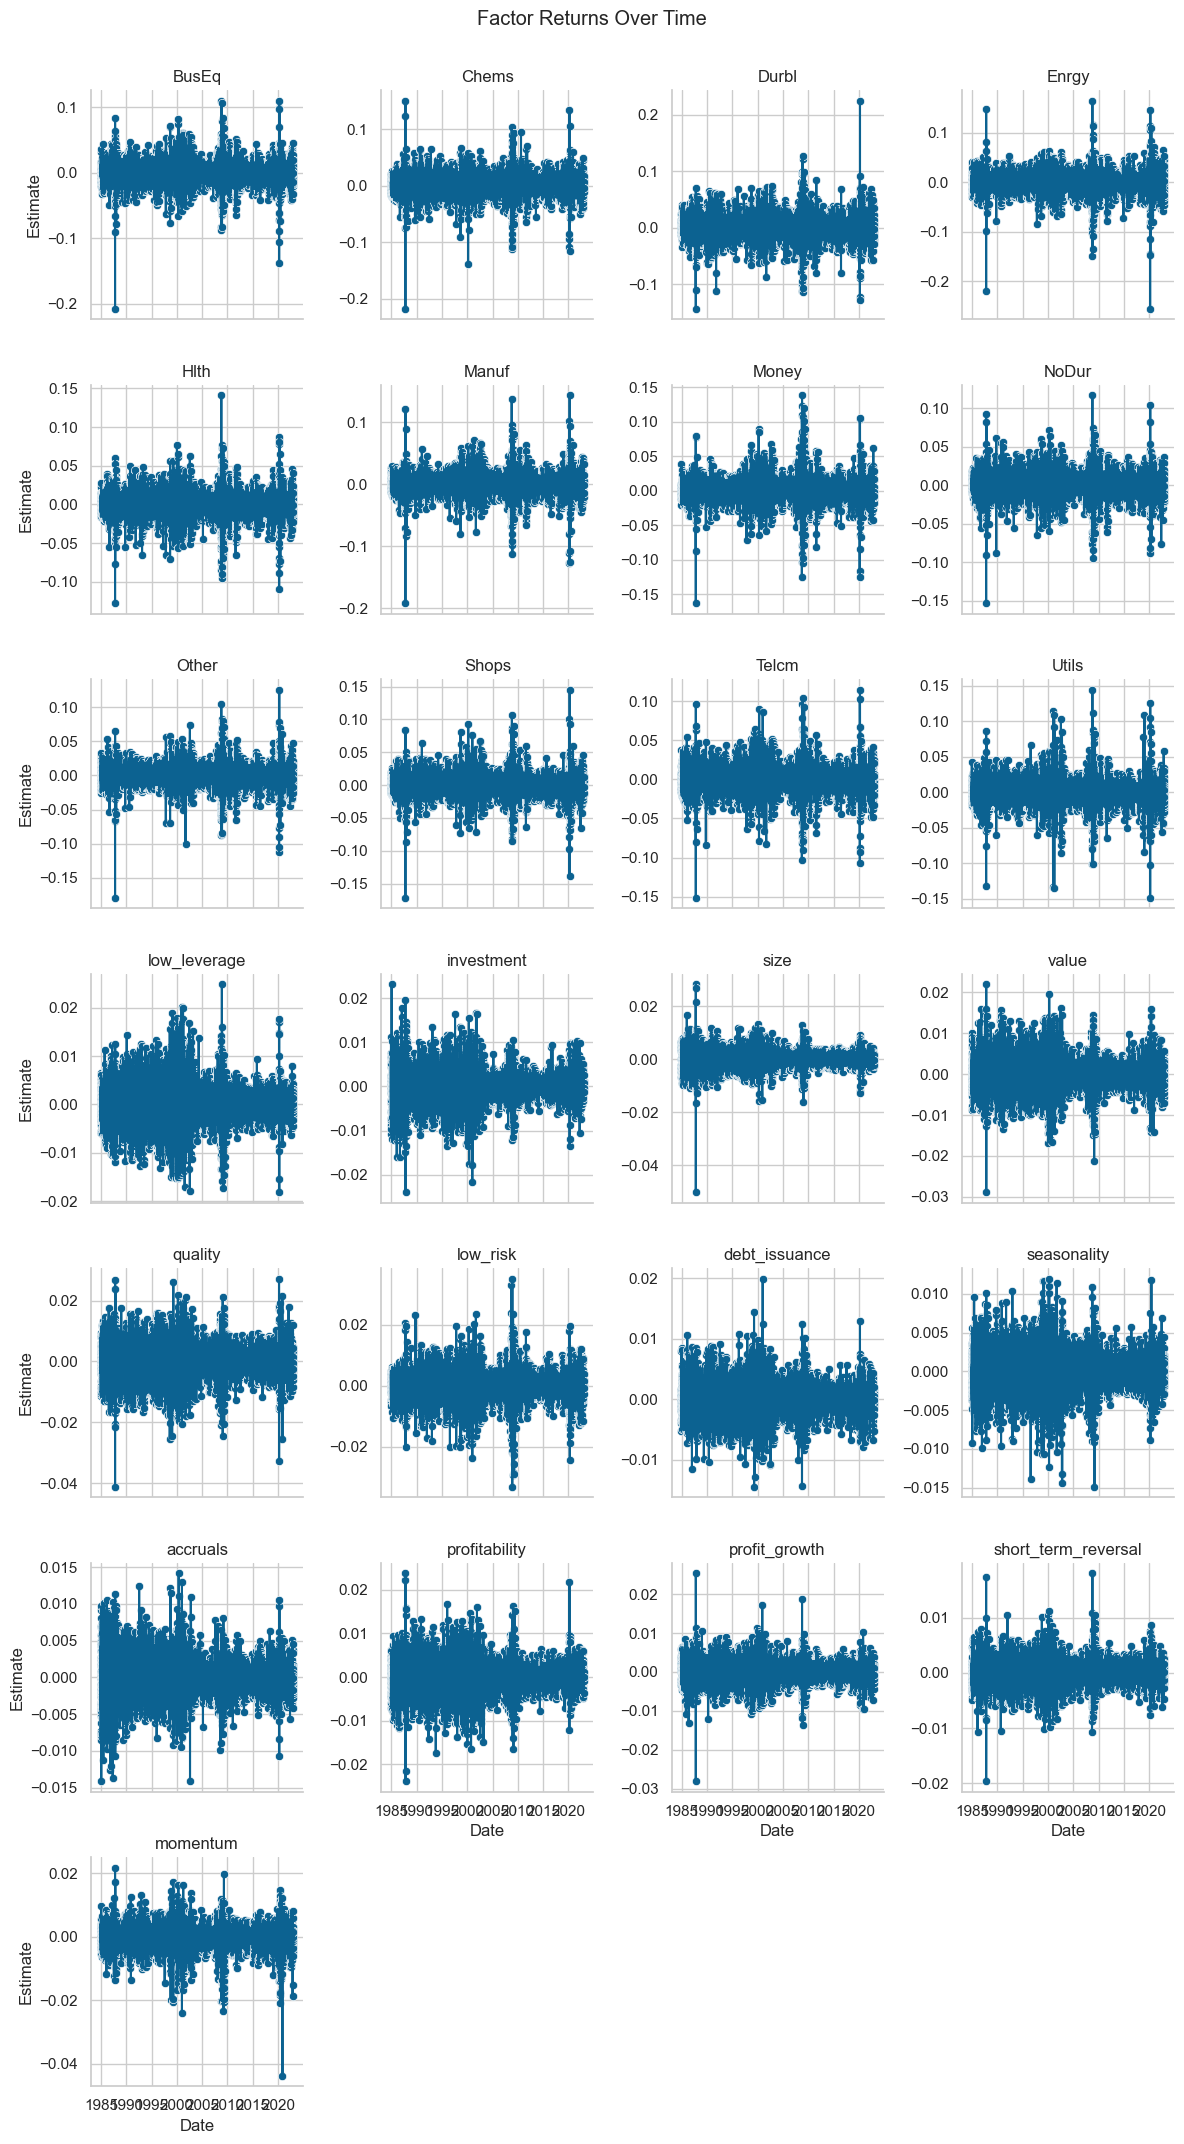

In [25]:
# Unnest tidy-data fra fct_ret_est
tidy_list = []
for idx, row in fct_ret_est.iterrows():
    tidy_df = row['tidied'].copy()
    tidy_df['date'] = row['date']
    tidy_list.append(tidy_df)
tidy_all = pd.concat(tidy_list, ignore_index=True)

# Hvis kolonnen med koefficienter hedder 'Coef.' eller 'Coef', omdøb til 'estimate'
if 'Coef.' in tidy_all.columns:
    tidy_all = tidy_all.rename(columns={'Coef.': 'estimate'})
elif 'Coef' in tidy_all.columns:
    tidy_all = tidy_all.rename(columns={'Coef': 'estimate'})

# 1. Plot: Faktorafkast over tid (facetteret efter term)
g = sns.FacetGrid(tidy_all, col="term", col_wrap=4, sharey=False, height=3)
g.map_dataframe(sns.lineplot, x="date", y="estimate")
g.map_dataframe(sns.scatterplot, x="date", y="estimate")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "Estimate")
g.fig.suptitle("Factor Returns Over Time", y=1.02)
plt.show()

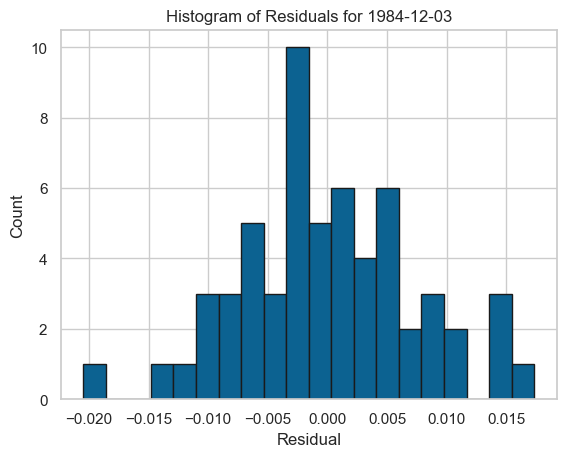

In [27]:
# 2. Residualanalyse for en specifik dato
# Vælg en specifik dato – her vælges den første række
row0 = fct_ret_est.iloc[0]
model = row0['fit']
residuals = model.resid
fitted = model.fittedvalues
date_val = row0['date']

# Histogram over residualer
plt.figure()
plt.hist(residuals, bins=20, edgecolor="k")
plt.title(f"Histogram of Residuals for {date_val.date()}")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

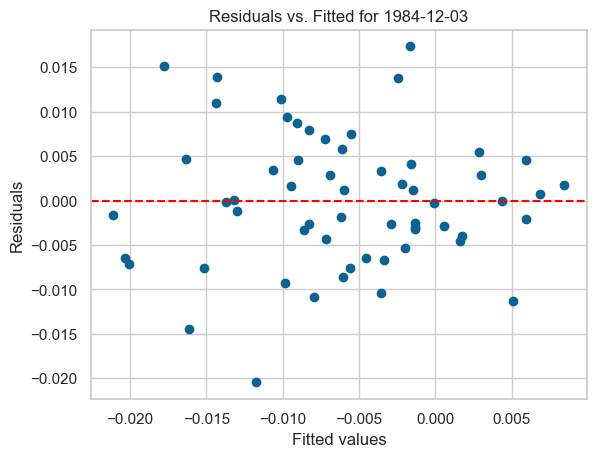

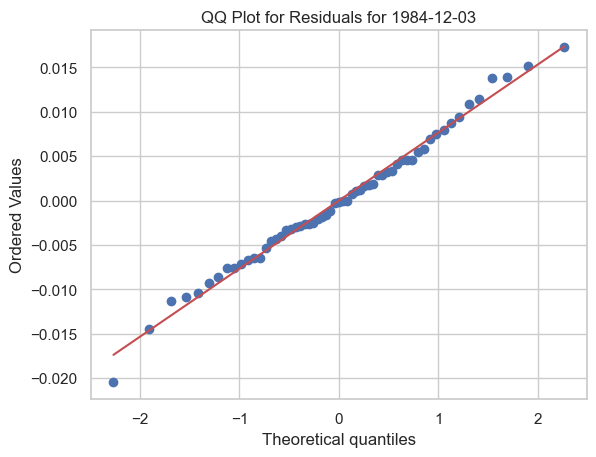

In [28]:
# Residual vs. Fitted plot
plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title(f"Residuals vs. Fitted for {date_val.date()}")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# QQ-plot for residualerne
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"QQ Plot for Residuals for {date_val.date()}")
plt.show()

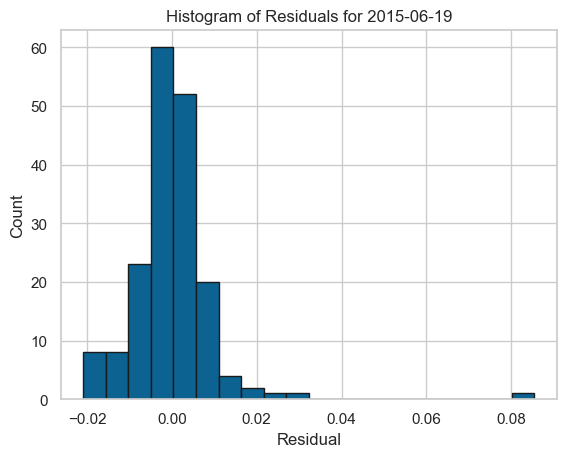

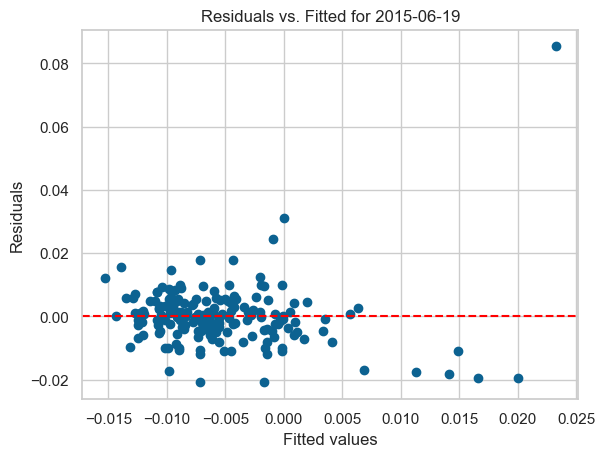

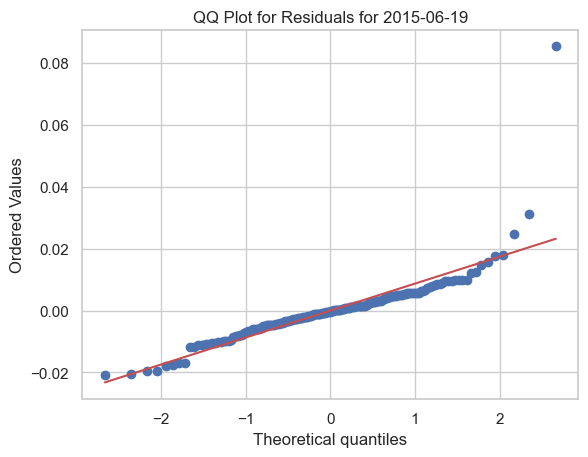

In [37]:
# 2. Residualanalyse for en specifik dato
# Vælg en specifik dato – her vælges den første række
row0 = fct_ret_est.iloc[7700]
model = row0['fit']
residuals = model.resid
fitted = model.fittedvalues
date_val = row0['date']

# Histogram over residualer
plt.figure()
plt.hist(residuals, bins=20, edgecolor="k")
plt.title(f"Histogram of Residuals for {date_val.date()}")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Residual vs. Fitted plot
plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title(f"Residuals vs. Fitted for {date_val.date()}")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# QQ-plot for residualerne
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"QQ Plot for Residuals for {date_val.date()}")
plt.show()

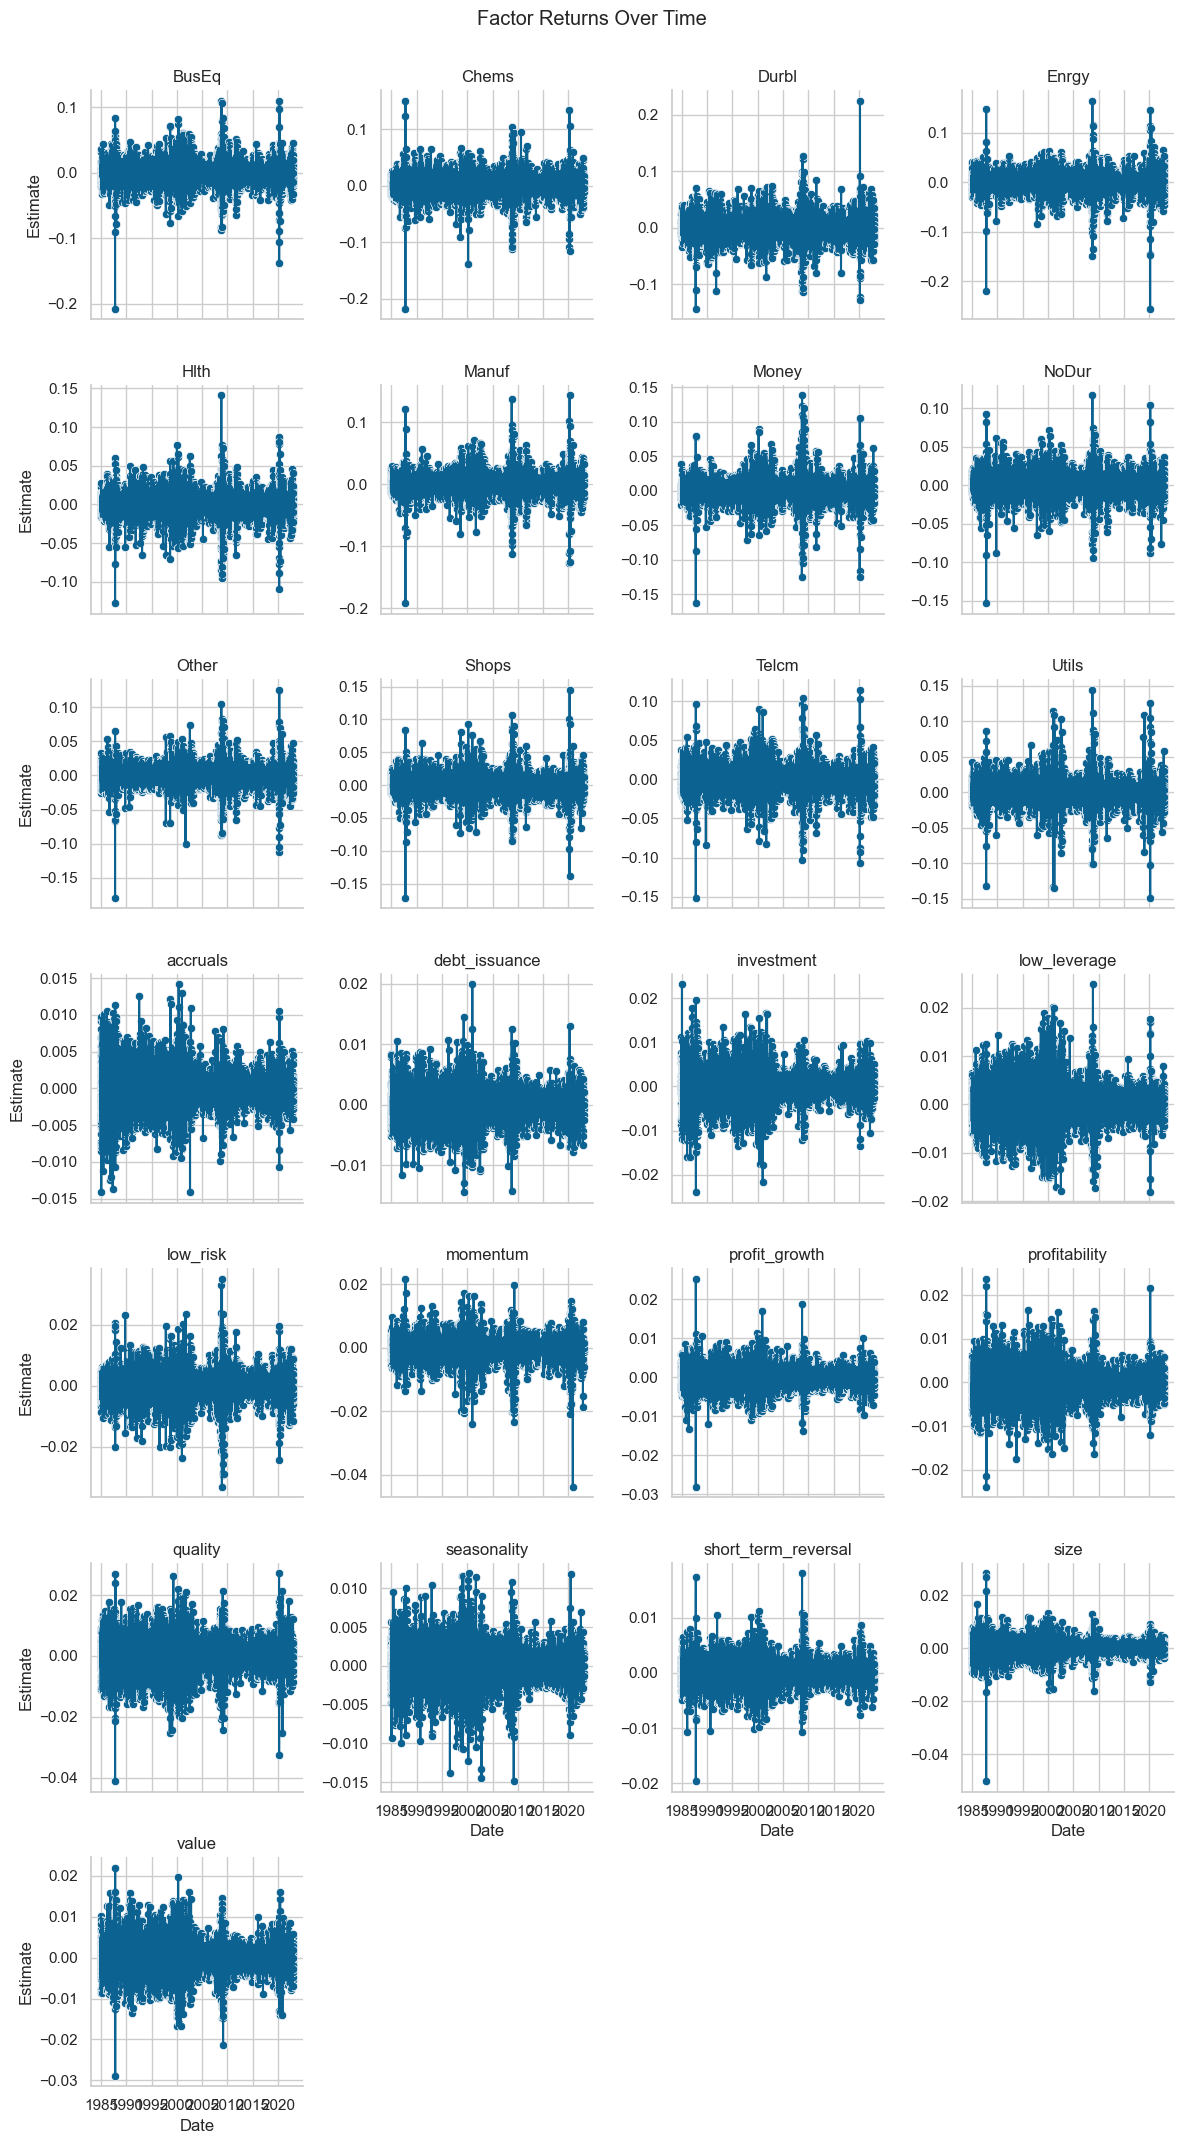

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Antag, at fct_ret er en DataFrame med 'date' og kolonner for de forskellige termer
# Smelt dataene til long format
fct_ret_long = fct_ret.melt(id_vars='date', var_name='term', value_name='estimate')

# Sørg for, at 'date' er datetime
fct_ret_long['date'] = pd.to_datetime(fct_ret_long['date'])

# Lav et facet-grid: Hver term i sin egen plot
g = sns.FacetGrid(fct_ret_long, col="term", col_wrap=4, sharey=False, height=3)
g.map_dataframe(sns.lineplot, x="date", y="estimate")
g.map_dataframe(sns.scatterplot, x="date", y="estimate")
g.set_axis_labels("Date", "Estimate")
g.set_titles("{col_name}")
g.fig.suptitle("Factor Returns Over Time", y=1.02)
plt.show()


In [40]:
print(fct_ret.shape)

(9598, 26)


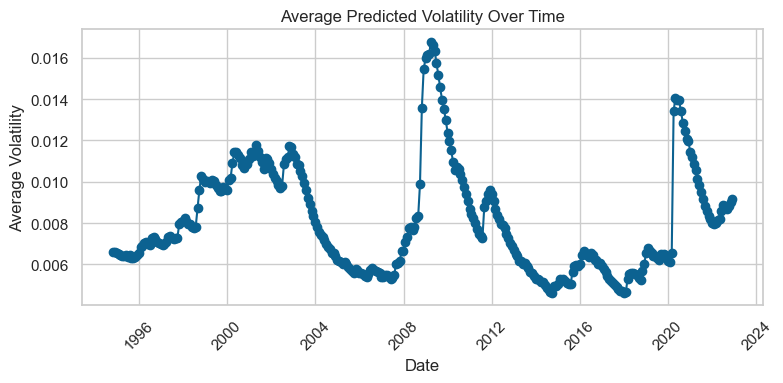

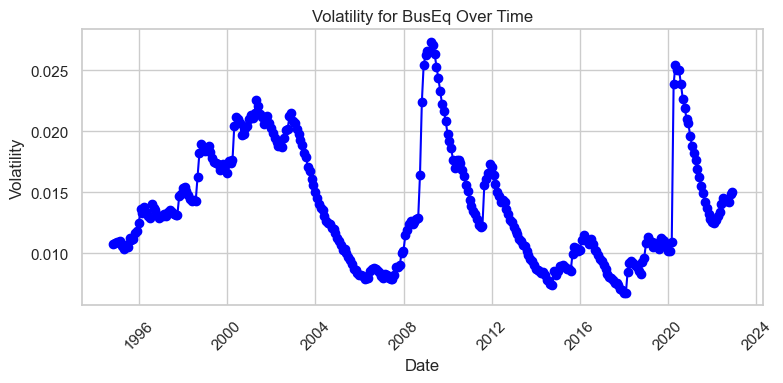

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Udtræk og beregn gennemsnitlig volatilitet for hver dato
vol_data = []
for d, mat in factor_cov_est.items():
    avg_vol = np.mean(np.sqrt(np.diag(mat.values)))
    vol_data.append({"date": pd.to_datetime(d), "avg_vol": avg_vol})
vol_data = pd.DataFrame(vol_data).sort_values("date")

# Plot: Gennemsnitlig forudsagt volatilitet over tid
plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["avg_vol"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Average Volatility")
plt.title("Average Predicted Volatility Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vælg en specifik faktor (fx den første kolonne i den første kovariansmatrix)
first_key = next(iter(factor_cov_est))
selected_factor = factor_cov_est[first_key].columns[0]

# Beregn volatilitet for den valgte faktor for hver dato
vol_data["selected_vol"] = [np.sqrt(mat.loc[selected_factor, selected_factor]) 
                            for mat in factor_cov_est.values()]

plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["selected_vol"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"Volatility for {selected_factor} Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


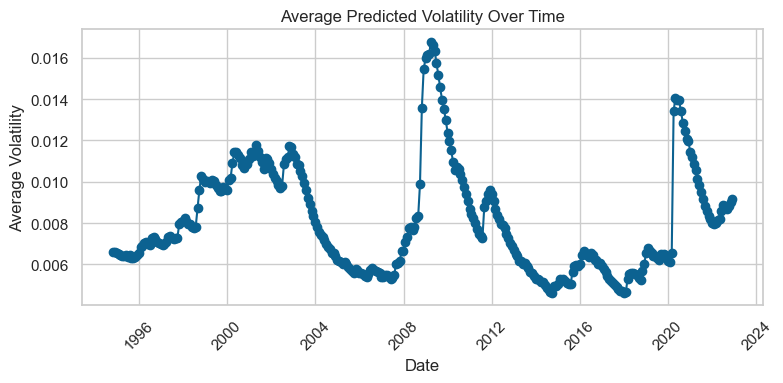

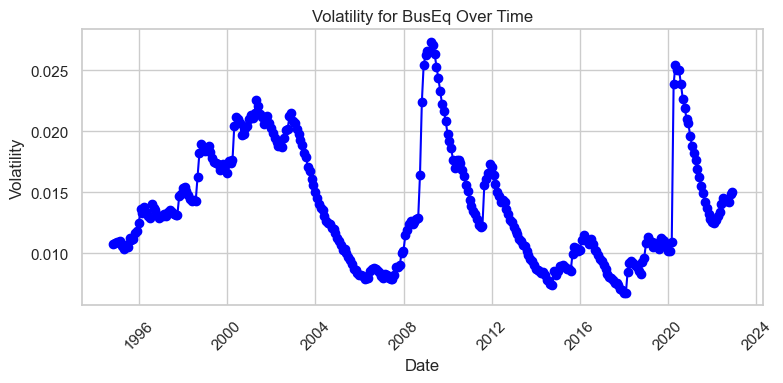

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Udtræk og beregn gennemsnitlig volatilitet for hver dato
vol_data = []
for d, mat in factor_cov_est.items():
    avg_vol = np.mean(np.sqrt(np.diag(mat.values)))
    vol_data.append({"date": pd.to_datetime(d), "avg_vol": avg_vol})
vol_data = pd.DataFrame(vol_data).sort_values("date")

# Plot: Gennemsnitlig forudsagt volatilitet over tid
plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["avg_vol"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Average Volatility")
plt.title("Average Predicted Volatility Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vælg en specifik faktor (fx den første kolonne i den første kovariansmatrix)
first_key = next(iter(factor_cov_est))
selected_factor = factor_cov_est[first_key].columns[0]

# Beregn volatilitet for den valgte faktor for hver dato
vol_data["selected_vol"] = [np.sqrt(mat.loc[selected_factor, selected_factor]) 
                            for mat in factor_cov_est.values()]

plt.figure(figsize=(8, 4))
plt.plot(vol_data["date"], vol_data["selected_vol"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"Volatility for {selected_factor} Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Symmetri-tjek:
{numpy.datetime64('1994-10-31T00:00:00.000000000'): True, numpy.datetime64('1994-11-30T00:00:00.000000000'): True, numpy.datetime64('1994-12-31T00:00:00.000000000'): True, numpy.datetime64('1995-01-31T00:00:00.000000000'): True, numpy.datetime64('1995-02-28T00:00:00.000000000'): True, numpy.datetime64('1995-03-31T00:00:00.000000000'): True, numpy.datetime64('1995-04-30T00:00:00.000000000'): True, numpy.datetime64('1995-05-31T00:00:00.000000000'): True, numpy.datetime64('1995-06-30T00:00:00.000000000'): True, numpy.datetime64('1995-07-31T00:00:00.000000000'): True, numpy.datetime64('1995-08-31T00:00:00.000000000'): True, numpy.datetime64('1995-09-30T00:00:00.000000000'): True, numpy.datetime64('1995-10-31T00:00:00.000000000'): True, numpy.datetime64('1995-11-30T00:00:00.000000000'): True, numpy.datetime64('1995-12-31T00:00:00.000000000'): True, numpy.datetime64('1996-01-31T00:00:00.000000000'): True, numpy.datetime64('1996-02-29T00:00:00.000000000'): True, numpy.datetime6

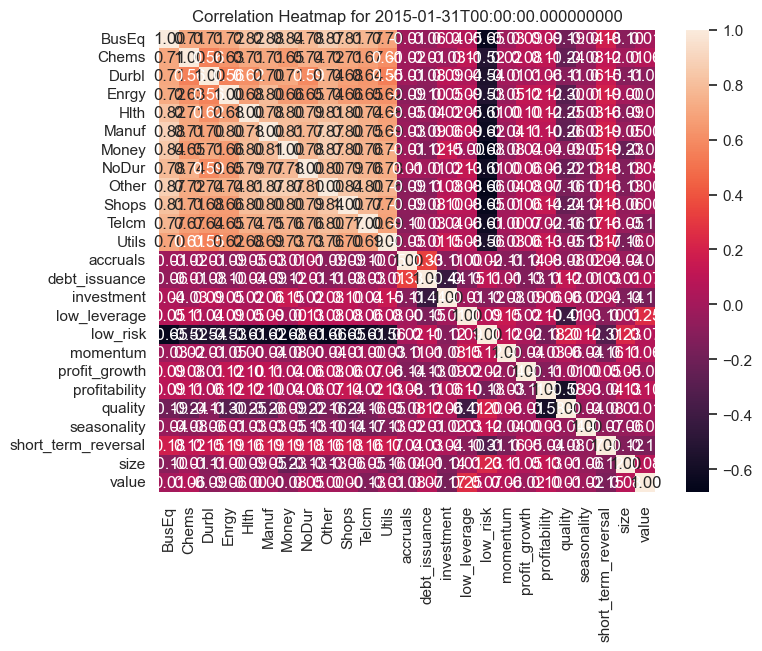

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funktion til at tjekke symmetri
def is_symmetric(mat):
    return np.allclose(mat, mat.T)

sym_checks = {d: is_symmetric(mat.values) for d, mat in factor_cov_est.items()}
print("Symmetri-tjek:")
print(sym_checks)

# Funktion til at tjekke positive semidefiniteness
def is_psd(mat):
    eigvals = np.linalg.eigvalsh(mat.values)
    return np.all(eigvals >= -1e-8)  # tolerance
psd_checks = {d: is_psd(mat) for d, mat in factor_cov_est.items()}
print("PSD-tjek:")
print(psd_checks)

# Vælg en specifik dato for at visualisere korrelationsmatrixen
selected_date = list(factor_cov_est.keys())[243]
cov_mat = factor_cov_est[selected_date].values

# Konverter covariance matrix til correlation matrix
std = np.sqrt(np.diag(cov_mat))
corr_mat = cov_mat / np.outer(std, std)
np.fill_diagonal(corr_mat, 1.0)

plt.figure(figsize=(8,6))
sns.heatmap(corr_mat, annot=True, fmt=".2f",
            xticklabels=factor_cov_est[selected_date].columns,
            yticklabels=factor_cov_est[selected_date].columns)
plt.title(f"Correlation Heatmap for {selected_date}")
plt.show()


In [84]:
#factor_cov_est

In [78]:
date_key = np.datetime64('1994-10-31', 'ns')  # 'ns' for nanosekunder
print(factor_cov_est[date_key])

                            BusEq         Chems         Durbl         Enrgy  \
BusEq                1.155408e-04  7.666353e-05  4.037356e-05  4.662482e-05   
Chems                7.666353e-05  2.457596e-04  4.650663e-05  5.915319e-05   
Durbl                4.037356e-05  4.650663e-05  1.646124e-04  3.419943e-05   
Enrgy                4.662482e-05  5.915319e-05  3.419943e-05  1.229910e-04   
Hlth                 5.193525e-05  7.812292e-05  3.580614e-05  3.050393e-05   
Manuf                5.355705e-05  6.329318e-05  4.156797e-05  4.428341e-05   
Money                3.926325e-05  4.164956e-05  2.855312e-05  3.243135e-05   
NoDur                6.004820e-05  9.051638e-05  4.157589e-05  3.702542e-05   
Other                3.773106e-05  4.275379e-05  3.467044e-05  3.906812e-05   
Shops                5.304279e-05  7.193783e-05  4.839199e-05  3.209945e-05   
Telcm                4.918380e-05  7.392379e-05  4.286039e-05  6.189612e-05   
Utils                5.673167e-05  6.972897e-05  4.1

In [79]:
date_key = np.datetime64('2015-12-31', 'ns')  # 'ns' for nanosekunder
print(factor_cov_est[date_key])

                            BusEq         Chems         Durbl         Enrgy  \
BusEq                1.064432e-04  8.077508e-05  9.553213e-05  1.001916e-04   
Chems                8.077508e-05  1.183154e-04  8.260359e-05  9.477881e-05   
Durbl                9.553213e-05  8.260359e-05  1.662139e-04  1.010094e-04   
Enrgy                1.001916e-04  9.477881e-05  1.010094e-04  1.955812e-04   
Hlth                 9.282291e-05  8.382334e-05  9.004083e-05  1.012931e-04   
Manuf                9.426532e-05  8.159447e-05  9.429286e-05  1.122139e-04   
Money                9.307427e-05  7.819646e-05  9.918841e-05  9.807778e-05   
NoDur                8.196481e-05  8.193223e-05  8.074351e-05  9.092430e-05   
Other                9.434229e-05  8.411024e-05  1.019758e-04  1.063233e-04   
Shops                7.881619e-05  7.270265e-05  8.435004e-05  8.658858e-05   
Telcm                7.847080e-05  7.202611e-05  8.257702e-05  8.775432e-05   
Utils                7.182467e-05  6.649514e-05  7.3

In [80]:
import pandas as pd
import numpy as np

records = []
for date_key, df in factor_cov_est.items():
    # Konverter covariance matrix til correlation matrix
    cov_mat = df.values
    std = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(std, std)
    # Sæt diagonalelementerne til NaN, så de ikke medtages i gennemsnittet
    np.fill_diagonal(corr_mat, np.nan)
    avg_corr = np.nanmean(corr_mat)
    # Konverter datoen til år
    year = pd.to_datetime(date_key).year
    records.append({"date": pd.to_datetime(date_key), "year": year, "avg_corr": avg_corr})

df_corr = pd.DataFrame(records)
avg_corr_by_year = df_corr.groupby("year")["avg_corr"].mean().reset_index()

print(avg_corr_by_year)


    year  avg_corr
0   1994  0.074310
1   1995  0.070031
2   1996  0.065933
3   1997  0.073109
4   1998  0.092206
5   1999  0.094443
6   2000  0.077162
7   2001  0.069383
8   2002  0.077934
9   2003  0.083694
10  2004  0.086930
11  2005  0.087069
12  2006  0.090333
13  2007  0.095793
14  2008  0.109009
15  2009  0.128895
16  2010  0.130605
17  2011  0.132344
18  2012  0.133486
19  2013  0.131989
20  2014  0.131755
21  2015  0.127802
22  2016  0.121600
23  2017  0.114279
24  2018  0.112134
25  2019  0.097657
26  2020  0.107570
27  2021  0.109530
28  2022  0.113057


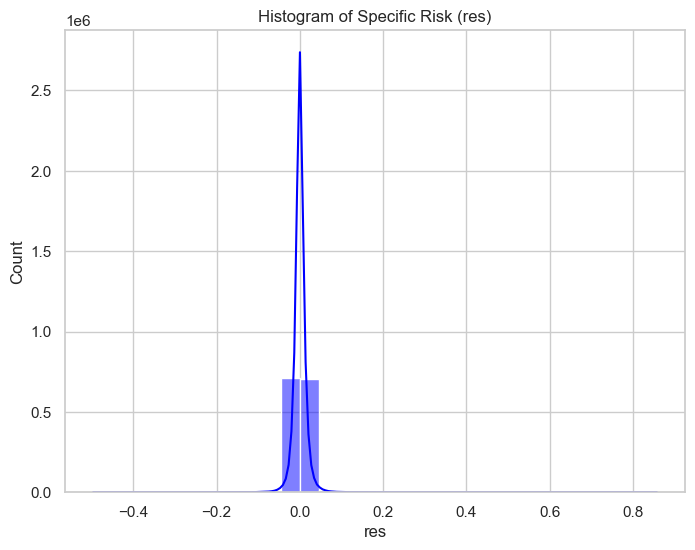

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(spec_risk['res'], bins=30, kde=True, color='blue')
plt.title("Histogram of Specific Risk (res)")
plt.xlabel("res")
plt.ylabel("Count")
plt.show()


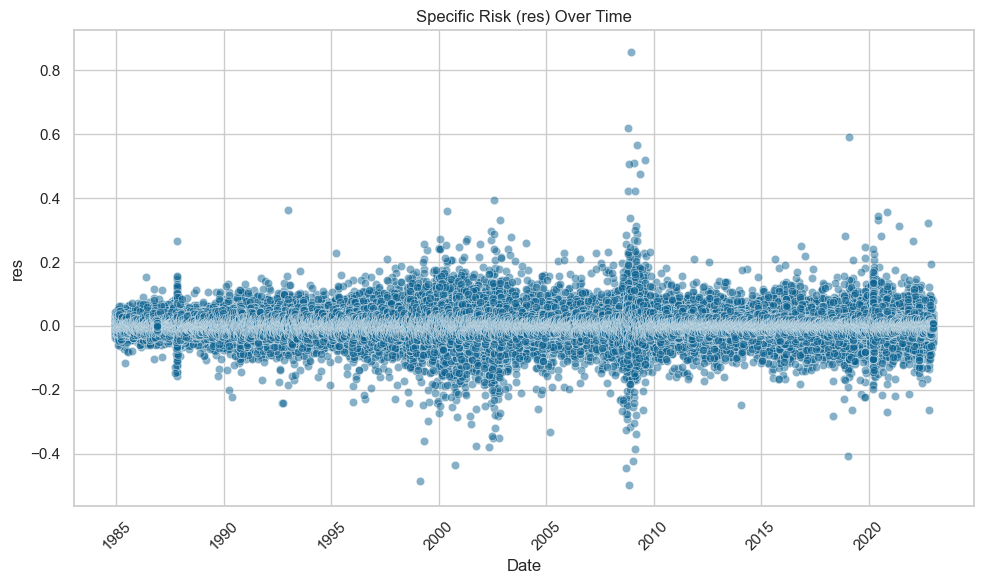

In [86]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=spec_risk, x='date', y='res', alpha=0.5)
plt.title("Specific Risk (res) Over Time")
plt.xlabel("Date")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


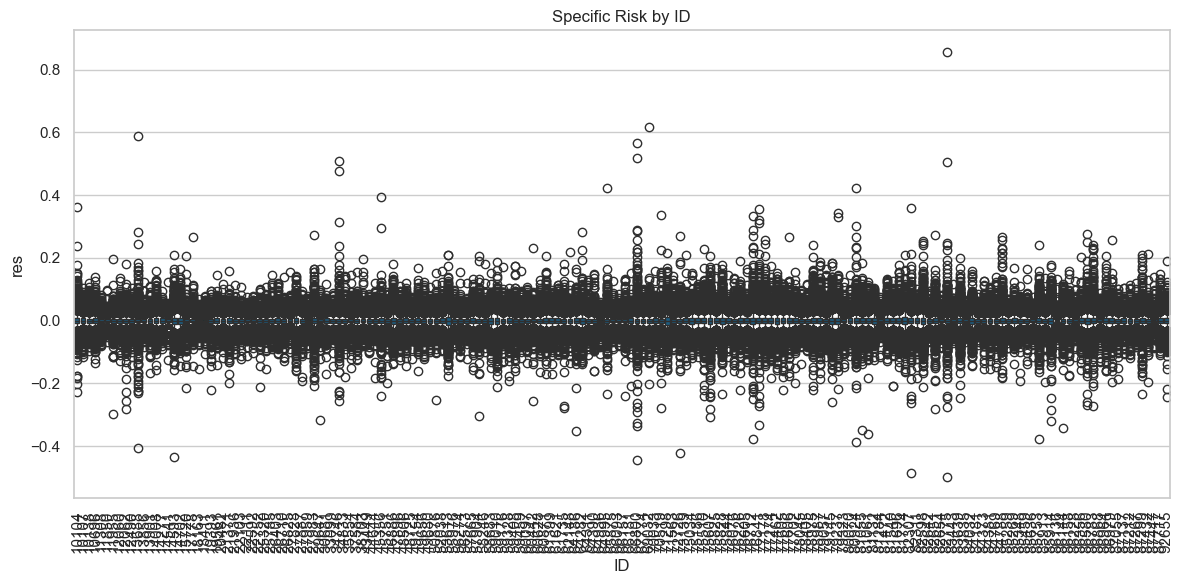

In [87]:
plt.figure(figsize=(12,6))
sns.boxplot(data=spec_risk, x='id', y='res')
plt.title("Specific Risk by ID")
plt.xlabel("ID")
plt.ylabel("res")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


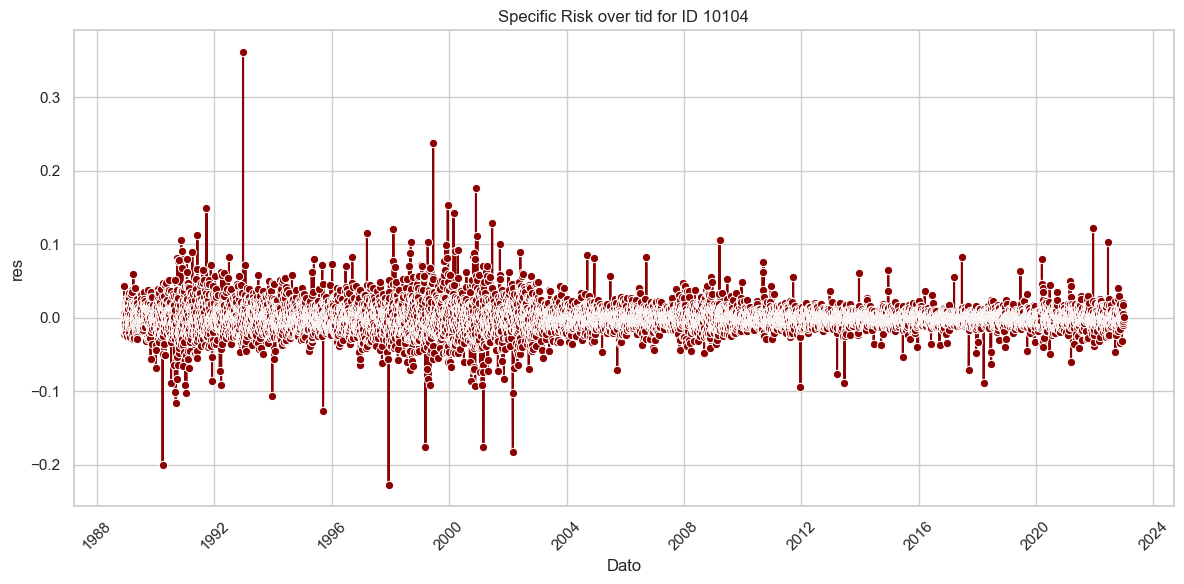

In [89]:
# Sørg for, at 'date' er datetime; f.eks. spec_risk['date'] = pd.to_datetime(spec_risk['date'])
spec_risk_10104 = spec_risk[spec_risk['id'] == 10104]

plt.figure(figsize=(12,6))
sns.lineplot(data=spec_risk_10104, x='date', y='res', marker='o', color='darkred')
plt.title("Specific Risk over tid for ID 10104")
plt.xlabel("Dato")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


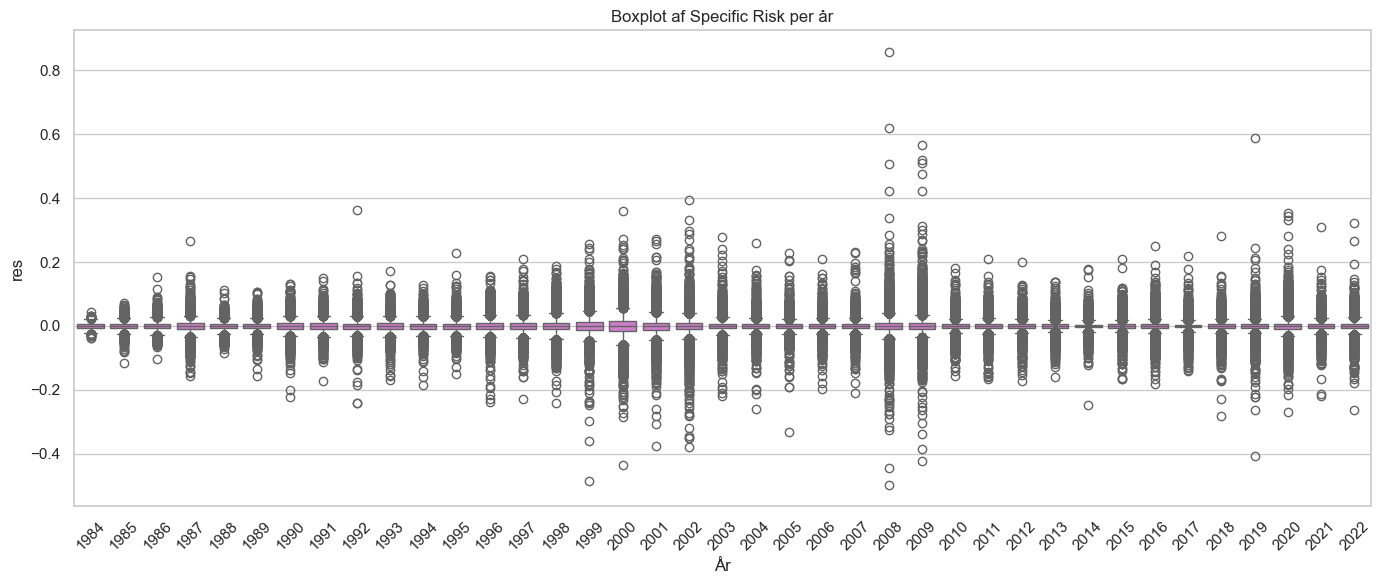

In [90]:
spec_risk['year'] = spec_risk['date'].dt.year

plt.figure(figsize=(14,6))
sns.boxplot(data=spec_risk, x='year', y='res', color='orchid')
plt.title("Boxplot af Specific Risk per år")
plt.xlabel("År")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


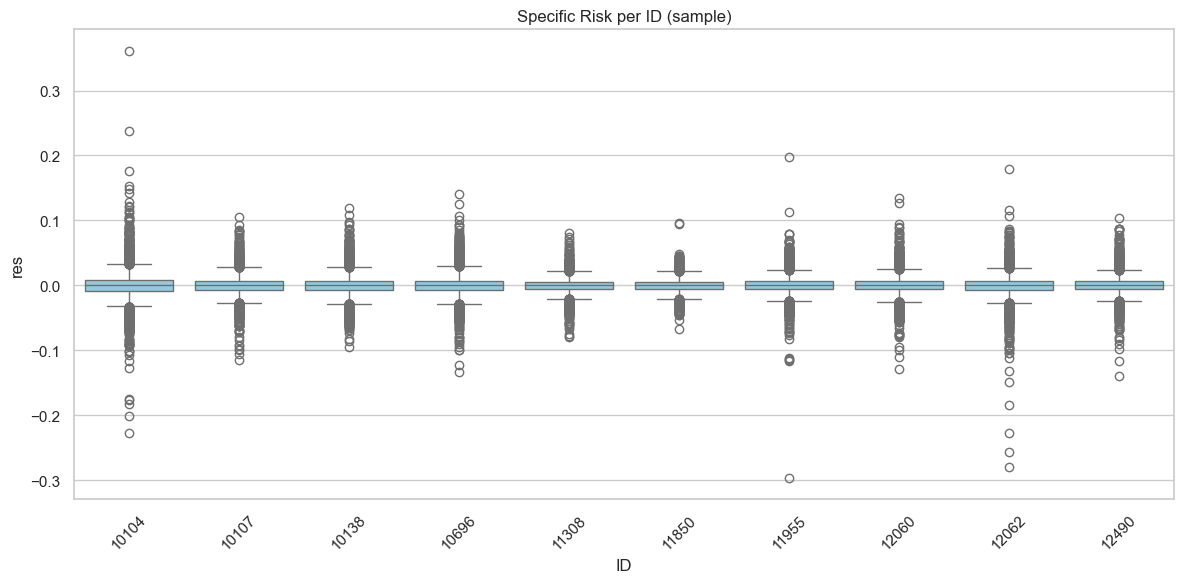

In [91]:
ids_sample = spec_risk['id'].unique()[:10]
spec_risk_sample = spec_risk[spec_risk['id'].isin(ids_sample)]

plt.figure(figsize=(12,6))
sns.boxplot(data=spec_risk_sample, x='id', y='res', color='skyblue')
plt.title("Specific Risk per ID (sample)")
plt.xlabel("ID")
plt.ylabel("res")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Dimensioner: (66710, 3)
Første 5 rækker:
        id        eom   res_vol
209  10104 1989-09-30  0.015939
231  10104 1989-10-31  0.016454
252  10104 1989-11-30  0.016532
272  10104 1989-12-31  0.015841
294  10104 1990-01-31  0.016954
Beskrivende statistik:
                 id                            eom       res_vol
count  66710.000000                          66710  6.671000e+04
mean   55161.335632  2006-11-06 21:40:20.326787840  1.398952e-02
min    10104.000000            1985-12-31 00:00:00  2.144357e-17
25%    27959.000000            1999-03-31 00:00:00  9.794293e-03
50%    60628.000000            2007-07-31 00:00:00  1.251073e-02
75%    78045.000000            2015-03-31 00:00:00  1.653867e-02
max    92655.000000            2022-12-31 00:00:00  9.358781e-02
std    25654.344153                            NaN  6.441381e-03


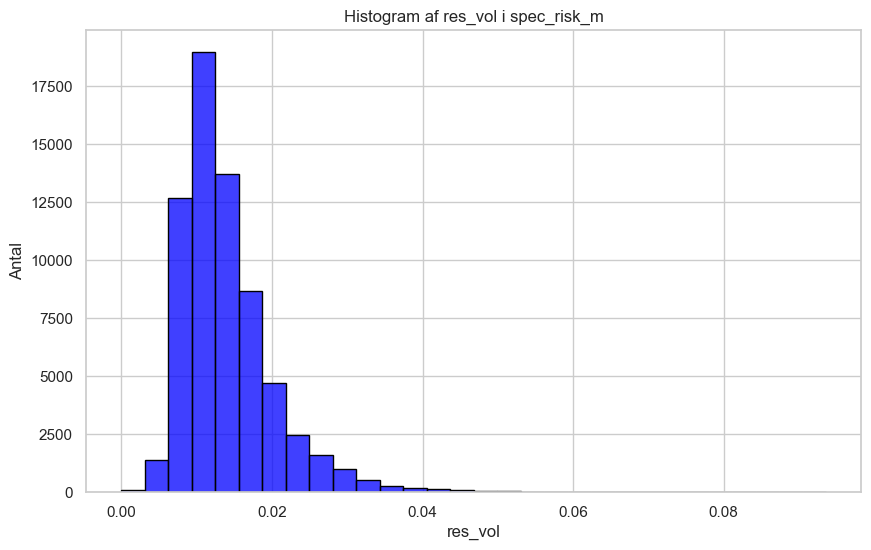

Unikke eom:
<DatetimeArray>
['1989-09-30 00:00:00', '1989-10-31 00:00:00', '1989-11-30 00:00:00',
 '1989-12-31 00:00:00', '1990-01-31 00:00:00', '1990-02-28 00:00:00',
 '1990-03-31 00:00:00', '1990-04-30 00:00:00', '1990-05-31 00:00:00',
 '1990-06-30 00:00:00']
Length: 10, dtype: datetime64[ns]


In [104]:
# Antag spec_risk_m er en Pandas DataFrame
print("Dimensioner:", spec_risk_m.shape)
print("Første 5 rækker:")
print(spec_risk_m.head())
print("Beskrivende statistik:")
print(spec_risk_m.describe())

# Histogram over res_vol
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(spec_risk_m['res_vol'], bins=30, color='blue', edgecolor='black')
plt.title("Histogram af res_vol i spec_risk_m")
plt.xlabel("res_vol")
plt.ylabel("Antal")
plt.show()

# Tjek unikke datoer (fx de første par datoer)
print("Unikke eom:")
print(spec_risk_m['eom'].unique()[:10])


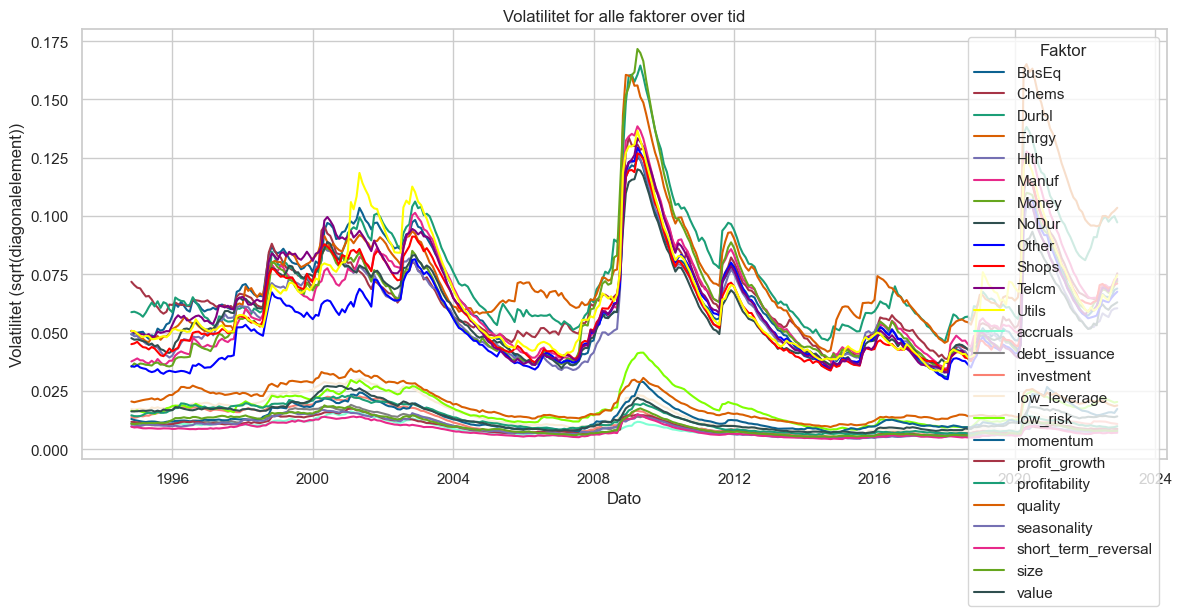

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forudsætning: barra_cov er en dictionary, hvor nøglerne er datoer,
# og hver værdi er en dictionary med en key 'fct_cov', der er en pandas DataFrame.
# Eksempel: barra_cov['2012-12-31']['fct_cov']

# Sorter datoerne
dates = sorted(barra_cov.keys())

# Hent faktornavne fra fct_cov for den første dato
first_date = dates[0]
factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Saml data: for hver dato og for hver faktor udregnes volatiliteten (sqrt af diagonalelementet)
records = []
for date in dates:
    df = barra_cov[date]['fct_cov']
    for factor in factor_names:
        vol = np.sqrt(df.loc[factor, factor])
        records.append({'date': pd.to_datetime(date), 'factor': factor, 'vol': vol})

# Konverter listen til en DataFrame
vol_data = pd.DataFrame(records)

# Plot: lav en linje for hver faktor over tid
plt.figure(figsize=(12, 6))
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    plt.plot(subset['date'], subset['vol'], label=factor)

plt.title("Volatilitet for alle faktorer over tid")
plt.xlabel("Dato")
plt.ylabel("Volatilitet (sqrt(diagonalelement))")
plt.legend(title="Faktor")
plt.tight_layout()
plt.show()
